In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
words = open("./data/names.txt", "r").read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
len(words)

32033

In [5]:
# build the vocabulary and the bigram mapping 

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i, s in enumerate(chars)}
stoi['.']  = 0
itos = {i:s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [87]:
def build_dataset(words):
    block_size = 3
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]
            
    X = torch.tensor(X)
    Y = torch.tensor(Y) 
    print(X.shape, Y.shape)
    return X, Y       

In [90]:
import random
random.seed(33)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))
Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])


torch.Size([182778, 3]) torch.Size([182778])
torch.Size([22633, 3]) torch.Size([22633])
torch.Size([22735, 3]) torch.Size([22735])


In [120]:
g = torch.Generator().manual_seed(33)
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g) 
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [121]:
sum(p.nelement() for p in parameters)

11897

In [122]:
for p in parameters:
    p.requires_grad = True

In [124]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre # learning rates spaces

In [125]:
lri = []
lossi = []
stepi = []

In [133]:
for i in range(50000):
    #minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    #forward pass
    emb = C[Xtr[ix]]
    h = torch.tanh(emb.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    # counts = logits.exp()
    # prob = counts / counts.sum(1, keepdim=True)
    # loss = -prob[torch.arange(32), Y].log().mean()
    loss = F.cross_entropy(logits, Ytr[ix]) # faster in forward pass(less memory with clustering opt), backward pass(more optimized grad calculatoin), numerically well behaved(the logits doesn't end with inf counts for positive logits by substracting the maximum logit, which still keep the same loss)
    
    #backward pass
    for p in parameters:
        p.grad = None
    loss.backward()    

    #update
    # lr = lrs[i]
    lr = 0.01
    for p in parameters:
        p.data += -lr * p.grad  
        
    #track stats    
    # lri.append(lre[i])
    lossi.append(loss.log10().item())    
    stepi.append(i)
        

print(loss.item())

1.8910794258117676


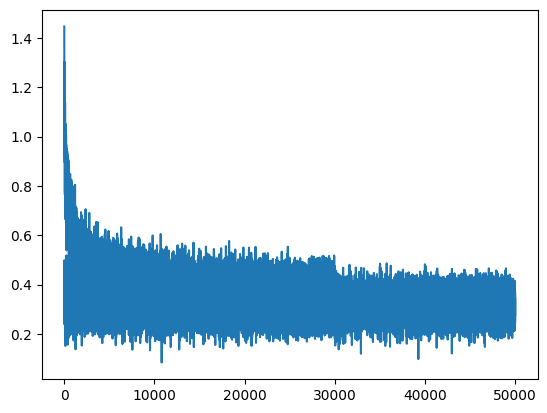

In [134]:
plt.plot(stepi, lossi)

In [135]:
emb = C[Xdev]
h = torch.tanh(emb.view(-1,30) @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.4335, grad_fn=<NllLossBackward0>)

In [137]:
#sample from the model
g = torch.Generator().manual_seed(33)
block_size = 3
for _ in range(20):
    out = []
    context = [0] * block_size
    
    while True:
        emb = C[torch.tensor([context])] 
        h = torch.tanh(emb.view(-1,30) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1::] + [ix]
        out.append(ix)
        if ix == 0:
            break
    
    print(''.join(itos[i] for i in out))    
        
        

jana.
den.
lucurulah.
jour.
nicall.
lib.
ros.
kayleah.
prion.
tory.
jana.
mareelan.
anaen.
jourdesli.
jermen.
hya.
ema.
aisleen.
audul.
maha.
